<a href="https://colab.research.google.com/github/HeeminYang/gAMza/blob/main/d2l_chap8_5_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l==0.17.5                                                        # 설치 후 runtime restart

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# RNN 처음부터 구현하기

- 8.4의 설명에 따라 character 단위 언어모델을 위한 RNN 구현하기
- H. G. 웰스의 타임머신 데이터셋 불러오기

In [2]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [3]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [4]:
vocab.token_freqs, len(vocab)

([(' ', 29927),
  ('e', 17838),
  ('t', 13515),
  ('a', 11704),
  ('i', 10138),
  ('n', 9917),
  ('o', 9758),
  ('s', 8486),
  ('h', 8257),
  ('r', 7674),
  ('d', 6337),
  ('l', 6146),
  ('m', 4043),
  ('u', 3805),
  ('c', 3424),
  ('f', 3354),
  ('w', 3225),
  ('g', 3075),
  ('y', 2679),
  ('p', 2427),
  ('b', 1897),
  ('v', 1295),
  ('k', 1087),
  ('x', 236),
  ('z', 144),
  ('j', 97),
  ('q', 95)],
 28)

In [5]:
next(iter(train_iter))

(tensor([[ 9,  5,  6,  ..., 12, 12,  2],
         [14, 21, 21,  ...,  1,  7, 14],
         [16,  7, 10,  ..., 11, 13,  5],
         ...,
         [ 1,  9,  2,  ...,  2,  1,  9],
         [ 2,  1,  8,  ..., 20, 12,  5],
         [ 3,  9,  2,  ..., 11,  7, 17]]),
 tensor([[ 5,  6,  2,  ..., 12,  2, 10],
         [21, 21, 12,  ...,  7, 14, 10],
         [ 7, 10,  2,  ..., 13,  5, 10],
         ...,
         [ 9,  2,  1,  ...,  1,  9,  2],
         [ 1,  8, 14,  ..., 12,  5, 15],
         [ 9,  2,  6,  ...,  7, 17,  6]]))

# **One-Hot Encoding**



- 각 토큰은 `train_iter`에 숫자 인덱스로 저장 되어있다. 

- 위 지수(인덱스)들을 직접 신경망에 넣으면 학습을 어렵게 만들기 때문에 토큰을 feature vector화 시킨다. 

- 여기서는 대표적인 방법으로 **One-Hot Encoding**을 사용한다.

- **One-Hot Encoding**은 단어 집합의 크기`len(vocab)`를 벡터의 차원으로 정하고, 표현할 단어의 인덱스에 값 1을 부여하고, 다른 인덱스에는 값 0을 부여하는 벡터 표현 방식이다.

- 토큰의 개수가 N = `len(vocab)`일때 토큰의 index는 0부터 N-1이다.

-  예시)

```
['나', '는', '자연어', '처리', '를', '배운다'] # 토큰의 개수 6개
단어 집합 : {'나': 0, '는': 1, '자연어': 2, '처리': 3, '를': 4, '배운다': 5} # 인덱스는 0부터 5까지
# '자연어'의 one-hot vector: 
[0, 0, 1, 0, 0, 0]
```

In [6]:
# 토큰 인덱스가 0 , 2인 one-hot 벡터
F.one_hot(torch.tensor([0, 2]), len(vocab))                                     

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

- **minibatch**의 모양은 `(batch size, number of time steps)` 인데, `one_hot` 함수를 통해 `len(vocab)`가 추가되어 3차원이 된다.
> `(batch size, number of time steps, len(vocab))`

- imput을 transpose하면 time steps를 통해 시간 순차적으로 볼 수 있다.

In [7]:
# X: 2x5, X.T: 5x2(time steps, batch size)
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

# 모델 파라미터 초기화(initialize)

- hidden state의 개수인 `num_hiddens`는 조정가능한 하이퍼파라미터다.

- 언어 모델 training시에 input과 output은 같은 vocabulary에서 나오기 때문에 차원의 값(vocabulary size)이 같다.

In [8]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # Hidden layer parameters
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # Attach gradients
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

# RNN Model

## init_rnn_state

- RNN Model을 정의하기위해 `init_rnn_state`함수를 사용한다.

- **`init_rnn_state`함수**는 hidden state를 반환한다.

  > 0으로 채워진 (batch_size, num_hidden) 모양의 텐서를 반환한다.

- 튜플을 사용하면 hidden state에 여러 변수가 포함되어 있는 상황을 보다 쉽게 처리할 수 있다. (중복을 허용하지 않는 특성)

In [9]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )
    # 튜플 형태로 반환
    # torch.zeros(행, 열)
    # device: 반환된 텐서의 원하는 장치

## rnn

- **`rnn` 함수**는 hidden state와 output의 계산 방법을 정의한다.

- RNN Model은 input의 바깥쪽 차원(`num_steps`)을 통해 Mini batch의 hidden state `H`를 time step 마다 업데이트한다.

- activation function은 tanh function를 사용한다.
  > 원소가 실수형태로 균일하게 분포 되어있다면, tanh function의 평균값은 0이다.

In [10]:
def rnn(inputs, state, params):
    # inputs의 구조: (num_steps, batch_size, vocab_size)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state 
    # state가 튜플 형식이서 첫번째 원소만 H로 가져오는데 state는 원소가 하나라 달라지는 것은 없음
    outputs = []
    # X의 구조: (batch_size, vocab_size)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,) # 똑같이 튜플 형식으로 반환

## Class 생성

- 필요한 모든 함수가 정의되면, 정의된 함수들을 가지고 RNN 모델에 대한 parameter들을 저장하는 클래스를 만든다.


In [11]:
class RNNModelScratch:
    """A RNN Model implemented from scratch."""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

## 검증

- output들이 올바른 구조인지 확인

> hidden state의 dimensionality가 변하지 않도록


In [12]:
X

tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])

In [13]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

- output 구조는 (number of time steps  ×  batch size, vocabulary size)인 반면, hidden state 구조는 그대로 유지된다는 것을 알 수 있다(batch size, number of hidden units).

# Prediction

- prediction 함수 정의

  > 제공한 `prefix`(접두사) 다음에 올 문자를 생성하는 함수

  > `prefix`: 여러 string이 포함된 문자열

## 워밍업 Period

- `prefix` 안의 시작 문자(beginnig character)를 반복시킬 때 output을 생성하지 않고 hidden state을 다음 step으로 전달한다.

- 이 기간 동안 모델은 스스로 업데이트(예: hidden state 업데이트)하지만 예측을 하지 않는다.

- 워밍업 기간이 지나면 hidden state는 일반적으로 처음에 initialized된 값보다 좋다.

In [14]:
def predict_ch8(prefix, num_preds, net, vocab, device):
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

## test `predict_ch8`
- `prefix`를 `time traveller`로 지정하고 10자를 생성한다.
- network을 훈련시키지 않았기 때문에 nonsensical prediction을 함

In [15]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller rti qpbxji'

# Gradient Clipping

- length $T$의 sequence에 대해, iteration 안에서 time steps $T$에 대한 gradient를 계산하고, 결과로 backpropagation 동안 $\mathcal{O}(T)$의 행렬 곱에 연결된다.

- 4.8장에 나오는 numerical stability에서와 같이, $T$가 큰 값일때 gradient가 eploding 되거나 vanishing 될 수 있다.

- 따라서, RNN 모델은 training을 stabilize하기 위해 추가적인 작업이 필요하다.

- optimaization을 진행할때, minibatch의 음의 gradient $\mathbf{g}$ 방향으로 model의 parameter(ex: vector $\mathbf{x}$)에 대한 업데이트를 진행한다.

- 예로, $\eta > 0$을 학습 속도로 하여 한 번 반복할때 $\mathbf{x}$를 $\mathbf{x} - \eta \mathbf{g}$로 업데이트하며, objective function $f$가 *Lipschitz continuous* 함수 $L$로 잘 동작한다고 가정한다.

  > *Lipschitz continuous*: 립시츠 연속 함수는 두 점 사이의 거리를 일정 비 이상으로 증가시키지 않는 함수다.

- 즉, 모든 $\mathbf{x}$와 $\mathbf{y}$에 대해 아래와 같다고 할 수 있다.
$$|f(\mathbf{x}) - f(\mathbf{y})| \leq L \|\mathbf{x} - \mathbf{y}\|$$

- 이 경우, 만약 우리가 parameter 벡터를 $\eta \mathbf{g}$으로 업데이트한다면, 
$$|f(\mathbf{x}) - f(\mathbf{x} - \eta\mathbf{g})| \leq L \eta\|\mathbf{g}\|$$


- $L \eta \|\mathbf{g}\|$ 이상의 변화를 관찰하지 않는 것을 볼 수 있다.

- 결론적으로, 잘못된 방향으로 가는 것을 막지만, progress의 속도도 제한한다.

- 때때로 gradient가 상당히 클 수 있고 optimization 알고리즘이 수렴되지 않을 수 있다.

-  대부분의 문제는 learning rate을 줄임으로 해결할 수 있지만, 큰 gradient를 거의 얻지 못한다면 lr를 줄이는것이 해결책이 될 수 없다.

- 대표적인 대안은 구의 반지름 $\theta$에 투영하여 gradient $\mathbf{g}$를 clipping하는 것이다.

**$$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}.$$**

- clipping을 통해 gradient norm이 $\theta$를 초과하지 않으며, 업데이트된 gradient가 $\mathbf{g}$의 기존 방향과 일치한다.

- 또한, minibatch가 parameter에 미치는 영향을 제한한다.

- gradient clipping은 gradient exploding을 방지하는 좋은 방법이다.

In [16]:
def grad_clipping(net, theta):
    """Clip the gradient."""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

# Training

- 모델을 훈련하기 전에 one epoch으로 모델을 훈련시키는 함수를 정의한다.

1. sequential data(random sampling 및 sequential partitioning)에 대한 다른 샘플링 방법은 hidden state의 initialization에 차이를 초래한다.

2. 모델 parameter들을 업데이트하기 전에 gradient를 clipping한다. 이를 통해 training process 중 특정 지점에서 gradient가 blow up하더라도 모델이 나뉘지(diverge) 않도록 한다.

3. 우리는 모델을 평가하기 위해 perplexity를 사용한다. 8.4.4 섹션에서 논의한 바와 같이, perplexity는 서로 다른 길이의 시퀀스를 비교할 수 있도록 보장한다.


- sequential partitioning할때 epoch의 시작에서만 hidden state를 initialize한다. 

- 다음 subsequence는 현재 subsequence와 이웃해 있기에, 현재 minibatch의 hidden state는 다음 minibatch 시작시 hidden state를 initialize할때 사용한다.

- 위 방식을 통해 hidden state에 저장된 sequence의 이전 정보는 이웃한 sequence를 통해 전달될 수 있다.

- random sampling을 사용할 때 각 subsequence들이 random 위치로 샘플링되므로 epoch마다 hidden state를 초기화해야 한다.

In [17]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """Train a net within one epoch (defined in Chapter 8)."""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize `state` when either it is the first iteration or
            # using random sampling
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # `state` is a tensor for `nn.GRU`
                state.detach_()
            else:
                # `state` is a tuple of tensors for `nn.LSTM` and
                # for our custom scratch implementation
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # Since the `mean` function has been invoked
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

교육 기능은 고급 API를 사용하여 구현된 RNN 모델을 지원한다.


In [18]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """Train a model (defined in Chapter 8)."""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # Initialize
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # Train and predict
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

## RNN 모델 훈련 

- data set에서 10000 개의 토큰만 사용하기 때문에 모델은 더 잘 수렴하기 위해 더 많은 epoch가 필요하다.

perplexity 1.0, 19032.0 tokens/sec on cpu
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


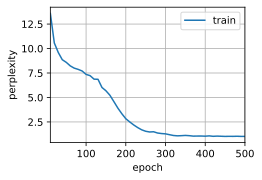

In [19]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

## 랜덤 샘플링 방법을 사용한 결과

perplexity 1.4, 17929.3 tokens/sec on cpu
time travellerit s against reason said filbycan a cube that does
traveller after the pauserequired for the proper assimilati


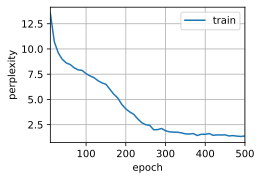

In [20]:
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)

- 위의 RNN 모델을 처음부터 구현하는 것은 유익하지만, 편리하지는 않다. 다음 섹션에서는 구현하기 쉽고 더 빨리 실행되도록 하는 방법과 같이 RNN 모델을 개선하는 방법에 대해 알아본다.


# Summary

* 우리는 RNN 기반의 character-level language model을 훈련시켜 사용자가 제공한 text `prefix`에 따라 텍스트를 생성할 수 있다.
* 간단한 RNN 언어 모델은 input encoding, RNN 모델링 및 output generation으로 구성된다.
* RNN 모델은 훈련을 위해 state initialization가 필요하지만, random sampling과 sequential partitioning은 다른 방법을 사용한다.
* 워밍업 period를 통해 모델은 예측하기 전에 스스로를 업데이트할 수 있다(예: initialized value보다 더 나은 hidden state를 얻을 수 있다).
* Gradient clipping은 gradient explosion을 방지하지만 vanishing gradients은 고칠 수 없다.

# Concise Implementation of Recurrent Neural Networks

섹션 8.5는 RNN이 어떻게 구현되는지 보는 데 도움이 되지만, 이는 편리하거나 빠르지 않다. 이 섹션에서는 deep learning framework의 High-level API에서 제공하는 기능을 사용하여 동일한 언어 모델을 보다 효율적으로 구현하는 방법을 보여 준다. 이전과 마찬가지로 time machine dataset 읽는 것으로 시작한다.

In [21]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

# **Defining the Model**

High-level API는 RNN을 제공한다. 단일 hidden layer와 256개의 hidden unit으로 `rnn_layer`를 구성한다. 

multiple layer는 9.3절에서 볼 수 있다. 지금은, multiple layer는 단순히 RNN의 다음 layer을 위한 input으로 사용되는 one layer의 output에 해당한다고 생각하면 충분하다.

In [22]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

우리는 텐서를 사용하여 hidden state를 초기화한다. 그 구조는 (number of hidden layers, batch size, number of *hidden* units)이다.

In [23]:
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

hidden state와 input을 사용하면 업데이트된 hidden state로 output을 계산할 수 있다. 

`rnn_layer`의 output `Y`는 output layer의 계산을 포함하지 않는다는 점이 중요하다. 

`Y`는 각 time step에서 hidden state를 나타내며 후속 output layer의 input으로 사용할 수 있다.

In [24]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

섹션 8.5와 마찬가지로 완전한 RNN 모델에 대한 `RNNModel` 클래스를 정의한다. 

`rnn_layer`에는 hidden recurrent layer만 포함되어 있으므로 별도의 output layer를 만들어야 한다.

In [25]:
class RNNModel(nn.Module):
    """The RNN model."""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        # If the RNN is bidirectional (to be introduced later),
        # `num_directions` should be 2, else it should be 1.
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # The fully connected layer will first change the shape of `Y` to
        # (`num_steps` * `batch_size`, `num_hiddens`). Its output shape is
        # (`num_steps` * `batch_size`, `vocab_size`).
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # `nn.GRU` takes a tensor as hidden state
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else:
            # `nn.LSTM` takes a tuple of hidden states
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

# Training and Predicting

모델을 training하기 전에 random weight가 있는 모델을 사용하여 예측해 본다.

In [26]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
d2l.predict_ch8('time traveller', 10, net, vocab, device)

'time travellerpjjspjupjj'

분명히 이 모델은 작동하지 않는다. 

다음으로, 섹션 8.5에 정의된 것과 동일한 하이퍼 매개 변수를 사용하여 train_ch8을 호출하고 고급 API로 모델을 학습한다.

perplexity 1.4, 64243.3 tokens/sec on cpu
time travellerit s agaidily rige cad reanthree dimensions but ho
travelleridut if outhe thing on tho heot orlcout the thong 


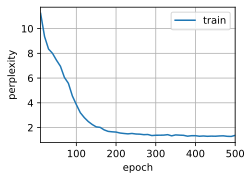

In [27]:
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)

지난 섹션과 비교했을 때, 이 모델은 심층 학습 프레임 워크의 고급 API에 의해 코드가 보다 최적화되어 있기 때문에 짧은 시간 내에 comparable한 perplexity으로 도달한다.

# Summary

* deep learning framework의 High-level API는 RNN layer의 구현을 제공한다.
* High-level API의 RNN layer는 output과 업데이트된 hidden state를 반환합니다. 여기서 output은 output layer의 계산을 포함하지 않습니다.
* High-level API를 사용하면 처음부터 구현을 사용하는 것보다 RNN training이 더 빠르다.

# Backpropagation Through Time, BPTT

RNN은 기존 신경망의 역전파(backprop)와는 달리 time step별로 네트워크를 펼친 다음, 역전파 알고리즘을 사용하는데 이를 BPTT(BackPropagation Through Time)라고 한다. 

BPTT 또한 일반적인 역전파와 같이 먼저 순전파(forward prop)로 각 타임 스텝별 시퀀스를 출력한다. 그런다음 이 출력 시퀀스와 손실(비용)함수를 사용하여 각 타임 스텝별 Loss를 구한다. 그리고 손실 함수의 그래디언트는 아래의 그림과 같이 펼쳐진 네트워크를 따라 역방향으로 전파된다. BPTT는 그래디언트가 마지막 타임 스텝인 출력뿐만 아니라 손실함수를 사용한 모든 출력에서 역방향으로 전파된다.

RNN은 각 타임 스텝마다 같은 parameter가 사용되기 때문에 역전파가 진행되면서 모든 타임 스텝에 걸쳐 parameter 값이 합산된다. 이렇게 업데이트된 가중치는 순전파 동안에는 모든 타임 스텝에 동일한 가중치가 적용된다.

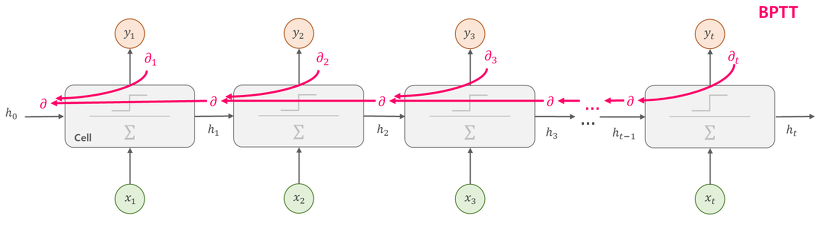

## Analysis of Gradients in RNNs

RNN이 어떻게 작동하는지에 대한 단순화 된 모델로 시작한다. 이 모델은 hidden state의 세부 정보와 업데이트 방법에 대한 세부 정보를 무시한다. 여기서 수학 표기법은 예전처럼 스칼라, 벡터 및 행렬을 명시적으로 구별하지 않는다. (분석에 중요하지 않으며 하위 섹션의 표기법을 혼란스럽게하는 역할을 하기 때문에)

이 단순화된 모델에선 아래와 같이 나타낸다.

$h_t$ = hidden state

$x_t$ = input

$o_t$ = output

$t$ = time step

섹션 8.4.2에서 input과 hidden state를 hidden layer에서 one weight variable로 곱하기 위해 연결할 수 있다고 함을 바탕으로, 

hidden layer와 output layer의 가중치를 나타내기 위해 $w_h$와 $w_o$를 사용한다.

결과적으로, 각 timestep의 hidden state와 output은 다음과 같이 설명될 수 있다.

(식 8.7.1)


$$\begin{aligned}h_t &= f(x_t, h_{t-1}, w_h),\\o_t &= g(h_t, w_o),\end{aligned}$$ 

여기서 $f$와 $g$는 각각  hidden layer과 the output layer의 변환(transformation)이다.

반복 계산을 통해 서로 의존하는 일련의 값 $\{\ldots, (x_{t-1}, h_{t-1}, o_{t-1}), (x_{t}, h_{t}, o_t), \ldots\}$이 있다.

순전파(forward propagation)하는 것은 꽤 간단하다. $(x_t, h_t, o_t)$ 삼중항들을 한 번에 한 단계씩 반복하는 것이다.

output $o_t$과 원하는 레이블 $y_t$ 사이의 불일치는 모든 $T$ time step에서 objective function에 의해 평가됩니다.  
(식 8.7.2)


$$L(x_1, \ldots, x_T, y_1, \ldots, y_T, w_h, w_o) = \frac{1}{T}\sum_{t=1}^T l(y_t, o_t).$$

역전파의 경우, objective function $L$의 parameters $w_h$에 대한 그라디언트를 계산할 때 문제는 약간 까다롭다.

(식 8.7.3)


$$\begin{aligned}\frac{\partial L}{\partial w_h}  & = \frac{1}{T}\sum_{t=1}^T \frac{\partial l(y_t, o_t)}{\partial w_h}  \\& = \frac{1}{T}\sum_{t=1}^T \frac{\partial l(y_t, o_t)}{\partial o_t} \frac{\partial g(h_t, w_o)}{\partial h_t}  \frac{\partial h_t}{\partial w_h}.\end{aligned}$$

위 식의 product의 첫 번째 및 두 번째 요인은 계산하기 쉽다.

세 번째 요인 $\partial h_t/\partial w_h$는 parameter $w_h$가 $h_t$에 미치는 영향을 반복적으로 계산해야 하기 때문에 상황이 까다로워지는 곳이다.

(식 8.7.1)의 반복 계산에 따르면, $h_t$ 는 $h_{t-1}$과 $w_h$ 모두에 따라 달라지며, 여기서 $h_{t-1}$의 계산도 $w_h$에 따라 달라진다.

(식 8.7.4)

$$\frac{\partial h_t}{\partial w_h}= \frac{\partial f(x_{t},h_{t-1},w_h)}{\partial w_h} +\frac{\partial f(x_{t},h_{t-1},w_h)}{\partial h_{t-1}} \frac{\partial h_{t-1}}{\partial w_h}.$$

위의 gradient를 도출하기 위해, 다음과 같이 가정한다.

세 시퀀스$\{a_{t}\},\{b_{t}\},\{c_{t}\}$가 $a_{0}=0$ and $a_{t}=b_{t}+c_{t}a_{t-1}$ for $t=1, 2,\ldots$를 만족한다.

$t\geq 1$일때,

(식 8.7.5)
$$a_{t}=b_{t}+\sum_{i=1}^{t-1}\left(\prod_{j=i+1}^{t}c_{j}\right)b_{i}.$$

$a_{t}, b_{t},c_{t}$를 아래에 따라 치환한다.

(식 8.7.6)
$$\begin{aligned}a_t &= \frac{\partial h_t}{\partial w_h},\\
b_t &= \frac{\partial f(x_{t},h_{t-1},w_h)}{\partial w_h}, \\
c_t &= \frac{\partial f(x_{t},h_{t-1},w_h)}{\partial h_{t-1}},\end{aligned}$$

(식 8.7.4)의 그레이디언트 계산은 $a_{t}=b_{t}+c_{t}a_{t-1}$을 만족한다. 따라서, (식 8.7.5)에 따라 (식 8.7.4)의 반복 계산을 다음과 같이 제거할 수 있다.

$$\frac{\partial h_t}{\partial w_h}=\frac{\partial f(x_{t},h_{t-1},w_h)}{\partial w_h}+\sum_{i=1}^{t-1}\left(\prod_{j=i+1}^{t} \frac{\partial f(x_{j},h_{j-1},w_h)}{\partial h_{j-1}} \right) \frac{\partial f(x_{i},h_{i-1},w_h)}{\partial w_h}.$$

체인 규칙을 사용하여 $\partial h_t/\partial w_h$를 재귀적으로(recursively) 계산할 수 있지만, 이 체인은 $t$가 클 때마다 매우 길어질 수 있다. 문제 해결 방법에 대해 알아본다.

### Full Computation ### 

당연히 (8.7.7)에 있는 전체 합계를 계산할 수 있으나, 초기 조건의 미묘한 변화가 잠재적으로 결과에 많은 영향을 미칠 수 있기 때문에 이것은 매우 느리고 gradient exploding이 일어날 수 있다. 따라서 이 전략은 실제로 거의 사용되지 않는다.


### Truncating Time Steps###

또는 $\tau$ 단계 후에 (8.7.7)에서 합계를 자를 수 있다. 결과로 모델이 주로 장기적인 결과보다는 단기적인 영향에 초점을 맞춘다. 이것은 추정을 더 단순하고 안정적인 모형으로 치우치기 때문에 실제로 바람직하다.

### Randomized Truncation ### 

마지막으로, $\partial h_t/\partial w_h$를 올바른 예측을 한 시퀀스를 잘라내는 랜덤 변수로 대체할 수 있습니다. 이 방법은 드물지만 적절하게 overweight이 되는 시퀀스의 가중치 합으로 이어진다.

truncated-bptt.svg

### Comparing Strategies

위 그림은 RNN에 대한 시간 역 전파를 사용하여 타임 머신 북의 처음 몇 글자를 분석할 때 다음과 같은 세 가지 전략을 보여준다. 
1. 첫 번째 행은 텍스트를 다양한 길이의 세그먼트로 분할하는 무작위 잘라내기다. 
2. 두 번째 행은 텍스트를 같은 길이의 연속체로 나누는 규칙적인 잘라내기다. 이것이 우리가 RNN 실험에서 해온 것이다. 
3. 세 번째 행은 계산적으로 실현 불가능한 표현으로 이어지는 BPTT다.

## Summary

* Backpropagation through time는 hidden state를 가진 시퀀스 모델에 역전파를 적용하는 것에 불과하다.
* Regular truncation 및 randomized truncation 같은 계산 편의성과 수치 안정성을 위해 truncation가 필요하다.
* 행렬의 높은 검정력은 분산(divergent)되거나 사라지는 고유값(vanishing eigenvalues)을 초래할 수 있다. 이것은 폭발하거나 사라지는 그레이디언트(exploding or vanishing gradients)의 형태로 나타난다.
* 효율적인 계산을 위해 중간 값은 시간에 따라 역전파되는 동안 임시저장(cached)된다.